# Modelo estatístico de previsão de chuva

**Grupo:**
> Breno Marti

> Diogo Cintra

> João Pedro Chacon Ruiz

> Luiz Felipe Valente

In [10]:
#Importando as bibliotecas
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange
from numpy import percentile
import numpy as np
from pandas import DataFrame
from scipy.stats import probplot
import statsmodels.api as sm

In [11]:
dados1 = pd.read_excel('previsao_chuva.xlsx')
dados1.head()

,codigo_estacao,data,hora,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,pto_orvalho_max,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_direcao,vento_vel,vento_rajada,radiacao,precipitacao
0,A401,2018-11-06,8,24.6,25.0,24.6,78,78.0,76.0,20.6,20.6,20.4,1006.7,1006.7,1006.2,0.8,64.0,5.2,NaN,0.0
1,A401,2018-11-06,16,29.9,31.1,29.8,56,62.0,55.0,20.2,22.1,20.2,1006.9,1007.6,1006.9,1.8,157.0,6.2,3389.0,0.0
2,A401,2018-11-06,4,24.7,25.2,24.7,77,80.0,75.0,20.4,21.3,20.2,1006.7,1007.1,1006.7,0.9,58.0,5.2,NaN,0.0
3,A401,2018-11-06,11,27.3,27.6,26.7,66,72.0,65.0,20.5,21.3,20.3,1008.9,1008.9,1008.1,1.9,65.0,5.7,1375.0,0.0
4,A401,2018-11-06,2,25.1,25.4,25.0,78,78.0,76.0,21.0,21.1,20.8,1007.6,1008.1,1007.6,1.2,90.0,5.0,NaN,0.0


In [12]:
datas = dados1.data
horas = dados1.hora

In [13]:
concat = []
for e in range(len(datas)):
    #concat.append(datas[e] + ',' + horas[e])
    d = datas[e]
    d = d.replace(hour=horas[e], minute=0, second=0)
    concat.append(d)
    
#print(concat)
dia_hora = pd.DataFrame(concat)

In [14]:
dados1.insert(0,'time', dia_hora, True)

In [15]:
dados_2 = dados1.drop(['data', 'hora'], axis=1)
dados_3 = dados_2.set_index("time")

dados2 = dados1.drop(['data', 'hora'], axis=1)
dados2.head()

,time,codigo_estacao,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,pto_orvalho_max,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_direcao,vento_vel,vento_rajada,radiacao,precipitacao
0,2018-11-06 08:00:00,A401,24.6,25.0,24.6,78,78.0,76.0,20.6,20.6,20.4,1006.7,1006.7,1006.2,0.8,64.0,5.2,NaN,0.0
1,2018-11-06 16:00:00,A401,29.9,31.1,29.8,56,62.0,55.0,20.2,22.1,20.2,1006.9,1007.6,1006.9,1.8,157.0,6.2,3389.0,0.0
2,2018-11-06 04:00:00,A401,24.7,25.2,24.7,77,80.0,75.0,20.4,21.3,20.2,1006.7,1007.1,1006.7,0.9,58.0,5.2,NaN,0.0
3,2018-11-06 11:00:00,A401,27.3,27.6,26.7,66,72.0,65.0,20.5,21.3,20.3,1008.9,1008.9,1008.1,1.9,65.0,5.7,1375.0,0.0
4,2018-11-06 02:00:00,A401,25.1,25.4,25.0,78,78.0,76.0,21.0,21.1,20.8,1007.6,1008.1,1007.6,1.2,90.0,5.0,NaN,0.0


___
#### Definindo as variáveis que vamos estudar 

In [17]:
dados_log = np.log(dados_3[['temp_inst','pressao','umid_inst','precipitacao','vento_vel']])

dados3 = dados2.transpose()
dados4 = dados3.loc[['time','temp_inst', 'pressao','umid_inst', 'precipitacao','vento_vel']]
dados5 = dados4.transpose()
dados5 = dados5.sort_values(by='time')
dados5 = dados5.reset_index()
del dados5['index']

In [18]:
data = []
hora = []

for coisas in dados5.time.astype(str):
    teste = coisas.split()
    data.append(teste[0])
    horas = teste[1]
    hora.append(horas[0:2])
    


In [19]:
final = []

anterior = data[0]
a=0
day = 0
for dia in data:
    if a < 8744:
        if data[a+1] == anterior:
            final.append(day)
        else:
            final.append(day)
            day += 1
            anterior = data[a+1]
    a += 1
final.append(364)

In [20]:
hora = pd.Series(hora).astype(int) 
final = pd.Series(final).astype(int)

In [21]:
dados5['horas'] = hora
dados5['dias'] = final

In [22]:
dados5['hora_seno'] = np.sin(2*np.pi*hora/24)
dados5['hora_cosseno'] = np.cos(2*np.pi*hora/24)

In [23]:
dados5['dia_seno'] = np.sin(2*np.pi*final/365.25)
dados5['dia_cosseno'] = np.cos(2*np.pi*final/365.25)
dados5

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel,horas,dias,hora_seno,hora_cosseno,dia_seno,dia_cosseno
0,2018-11-06 00:00:00,25.3,1008.1,76,0,74,0,0,0.000000e+00,1.000000e+00,0.000000,1.000000
1,2018-11-06 01:00:00,25.2,1008.1,78,0,69,1,0,2.588190e-01,9.659258e-01,0.000000,1.000000
2,2018-11-06 02:00:00,25.1,1007.6,78,0,90,2,0,5.000000e-01,8.660254e-01,0.000000,1.000000
3,2018-11-06 03:00:00,25.2,1007.1,79,0,95,3,0,7.071068e-01,7.071068e-01,0.000000,1.000000
4,2018-11-06 04:00:00,24.7,1006.7,77,0,58,4,0,8.660254e-01,5.000000e-01,0.000000,1.000000
5,2018-11-06 05:00:00,25.4,1006.2,76,0,67,5,0,9.659258e-01,2.588190e-01,0.000000,1.000000
6,2018-11-06 06:00:00,25.3,1005.7,76,0,73,6,0,1.000000e+00,6.123234e-17,0.000000,1.000000
7,2018-11-06 07:00:00,24.9,1006.3,76,0,77,7,0,9.659258e-01,-2.588190e-01,0.000000,1.000000
8,2018-11-06 08:00:00,24.6,1006.7,78,0,64,8,0,8.660254e-01,-5.000000e-01,0.000000,1.000000
9,2018-11-06 09:00:00,25.6,1007.3,75,0,64,9,0,7.071068e-01,-7.071068e-01,0.000000,1.000000


## Organização de DataFrames

> Estes são feitos a fim de possibilitar a análise do evento a partir dos dados advindos das horas que o precedem e do instante em sí

In [24]:
dados6 = dados5.set_index('time')
t = [] #hora de chuva
t1 = [] #uma hora anterior
t2 = [] #duas horas anteriores
t3 = [] #tres horas anteriores
t4 = [] #quatro horas anteriores

for e in range(len(dados6)):
    
    if dados6['precipitacao'][e]>0:
        t.append(dados6.iloc[e])
        t1.append(dados6.iloc[e-1])
        t2.append(dados6.iloc[e-2])
        t3.append(dados6.iloc[e-3])
        t4.append(dados6.iloc[e-4])

# Guardando as listas como DataFrames
T = pd.DataFrame(t)
T1 = pd.DataFrame(t1)
T2 = pd.DataFrame(t2)
T3 = pd.DataFrame(t3)
T4 = pd.DataFrame(t4)

# Renomeando as colunas de todos estes DataFrames -  0 Horas
T.rename(columns={'temp_inst':'temperatura_t'}, inplace=True)
T.rename(columns={'pressao':'pressao_t'}, inplace=True)
T.rename(columns={'umid_inst':'umidade_t'}, inplace=True)
T.rename(columns={'precipitacao':'precipitacao_t'}, inplace=True)
T.rename(columns={'vento_vel':'vento_t'}, inplace=True)
T[['temperatura_t', 'pressao_t', 'umidade_t','precipitacao_t','vento_t']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  1 Hora atrás
T1.rename(columns={'temp_inst':'temperatura_t1'}, inplace=True)
T1.rename(columns={'pressao':'pressao_t1'}, inplace=True)
T1.rename(columns={'umid_inst':'umidade_t1'}, inplace=True)
T1.rename(columns={'precipitacao':'precipitacao_t1'}, inplace=True)
T1.rename(columns={'vento_vel':'vento_t1'}, inplace=True)
T1[['temperatura_t1', 'pressao_t1', 'umidade_t1','precipitacao_t1','vento_t1']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  2 Horas atrás
T2.rename(columns={'temp_inst':'temperatura_t2'}, inplace=True)
T2.rename(columns={'pressao':'pressao_t2'}, inplace=True)
T2.rename(columns={'umid_inst':'umidade_t2'}, inplace=True)
T2.rename(columns={'precipitacao':'precipitacao_t2'}, inplace=True)
T2.rename(columns={'vento_vel':'vento_t2'}, inplace=True)
T2[['temperatura_t2', 'pressao_t2', 'umidade_t2','precipitacao_t2','vento_t2']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  3 Horas atrás
T3.rename(columns={'temp_inst':'temperatura_t3'}, inplace=True)
T3.rename(columns={'pressao':'pressao_t3'}, inplace=True)
T3.rename(columns={'umid_inst':'umidade_t3'}, inplace=True)
T3.rename(columns={'precipitacao':'precipitacao_t3'}, inplace=True)
T3.rename(columns={'vento_vel':'vento_t3'}, inplace=True)
T3[['temperatura_t3', 'pressao_t3', 'umidade_t3','precipitacao_t3','vento_t3']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  4 Horas atrás
T4.rename(columns={'temp_inst':'temperatura_t4'}, inplace=True)
T4.rename(columns={'pressao':'pressao_t4'}, inplace=True)
T4.rename(columns={'umid_inst':'umidade_t4'}, inplace=True)
T4.rename(columns={'precipitacao':'precipitacao_t4'}, inplace=True)
T4.rename(columns={'vento_vel':'vento_t4'}, inplace=True)
T4[['temperatura_t4', 'pressao_t4', 'umidade_t4','precipitacao_t4','vento_t4']].astype(float);



### Análise para que se possa escolher a melhor hora a ser usada para que se faça a previsão

Obs: o valor de t é referente ao tempo no qual os dados foram obtidos em relação ao horário de precipitação, t, t1, t2, t3, t4 representam 0, 1, 2, 3 e 4 horas atrás, respectivamente

> Correlação entre os dados de umidade nas horas anteriores com os dados de precipitação

In [25]:
print('Correlação entre precipitação e umidade:',np.log10(T['precipitacao_t']).corr(T['umidade_t']))

Correlação entre precipitação e umidade: 0.4059043809724464


In [26]:
print('Correlação entre precipitação e umidade:',np.log10(T['precipitacao_t']).corr(T1['umidade_t1']))

Correlação entre precipitação e umidade: 0.3669642756902318


In [27]:
print('Correlação entre precipitação e umidade:',np.log10(T['precipitacao_t']).corr(T2['umidade_t2']))

Correlação entre precipitação e umidade: 0.43393318880933707


In [28]:
print('Correlação entre precipitação e umidade:',np.log10(T['precipitacao_t']).corr(T3['umidade_t3']))

Correlação entre precipitação e umidade: 0.4191598114765586


In [29]:
print('Correlação entre precipitação e umidade:',np.log10(T['precipitacao_t']).corr(T4['umidade_t4']))

Correlação entre precipitação e umidade: 0.40374297404626874


> Correlação entre os dados de temperatura nas horas anteriores com os dados de precipitação

In [30]:
print('Correlação entre precipitação e temperatura:',np.log10(T['precipitacao_t']).corr(T['temperatura_t']))

Correlação entre precipitação e temperatura: -0.19685016544813258


In [31]:
print('Correlação entre precipitação e temperatura:',np.log10(T['precipitacao_t']).corr(T1['temperatura_t1']))

Correlação entre precipitação e temperatura: -0.0746692117232901


In [32]:
print('Correlação entre precipitação e temperatura:',np.log10(T['precipitacao_t']).corr(T2['temperatura_t2']))

Correlação entre precipitação e temperatura: -0.1310409181100207


In [33]:
print('Correlação entre precipitação e temperatura:',np.log10(T['precipitacao_t']).corr(T3['temperatura_t3']))

Correlação entre precipitação e temperatura: -0.1332973312175553


In [34]:
print('Correlação entre precipitação e temperatura:',np.log10(T['precipitacao_t']).corr(T4['temperatura_t4']))

Correlação entre precipitação e temperatura: -0.10626954813227171


> Correlação entre os dados de pressão atmosférica nas horas anteriores com os dados de precipitação

In [35]:
print('Correlação entre precipitação e pressão atmosférica:',np.log10(T['precipitacao_t']).corr(T['pressao_t']))

Correlação entre precipitação e pressão atmosférica: -0.03963987120695976


In [36]:
print('Correlação entre precipitação e pressão atmosférica:',np.log10(T['precipitacao_t']).corr(T1['pressao_t1']))

Correlação entre precipitação e pressão atmosférica: -0.09544328309973367


In [37]:
print('Correlação entre precipitação e pressão atmosférica:',np.log10(T['precipitacao_t']).corr(T2['pressao_t2']))

Correlação entre precipitação e pressão atmosférica: -0.0947990428821265


In [38]:
print('Correlação entre precipitação e pressão atmosférica:',np.log10(T['precipitacao_t']).corr(T3['pressao_t3']))

Correlação entre precipitação e pressão atmosférica: -0.07977190244656183


In [39]:
print('Correlação entre precipitação e pressão atmosférica:',np.log10(T['precipitacao_t']).corr(T4['pressao_t4']))

Correlação entre precipitação e pressão atmosférica: -0.0770452095746837


> Correlação entre os dados de velocidade do vento nas horas anteriores com os dados de precipitação

In [40]:
print('Correlação entre pressão e velocidade do vento:',np.log10((T['precipitacao_t'])).corr(T['vento_t']))

Correlação entre pressão e velocidade do vento: 0.08699705229547013


In [41]:
print('Correlação entre pressão e velocidade do vento:',np.log10((T['precipitacao_t'])).corr(T1['vento_t1']))

Correlação entre pressão e velocidade do vento: 0.09691150727993726


In [42]:
print('Correlação entre pressão e velocidade do vento:',np.log10((T['precipitacao_t'])).corr(T2['vento_t2']))

Correlação entre pressão e velocidade do vento: 0.07401340884689199


In [43]:
print('Correlação entre pressão e velocidade do vento:',np.log10((T['precipitacao_t'])).corr(T3['vento_t3']))

Correlação entre pressão e velocidade do vento: 0.11039405364947277


In [44]:
print('Correlação entre pressão e velocidade do vento:',np.log10((T['precipitacao_t'])).corr(T4['vento_t4']))

Correlação entre pressão e velocidade do vento: 0.06715712624722905


 A partir das análises feitas nessas células pode-se concluir que a hora t3, ou seja, 3 horas antes do ocorrido, mostra uma correlação consistentemente maior que as outras faixas de tempo

___
## Analisando os dias que tiveram chuvas

### Análise com log

In [45]:
dados_log_com_chuva = dados_log[dados_log['precipitacao']>0]
dados_log_com_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-07 01:00:00,3.161247,6.916418,4.477337,1.098612,2.564949
2018-11-08 02:00:00,3.131137,6.916517,4.488636,1.526056,4.859812
2018-11-08 03:00:00,3.144152,6.915723,4.510860,0.693147,5.877736
2018-11-08 08:00:00,3.144152,6.914532,4.532599,2.079442,3.688879
2018-11-08 10:00:00,3.173878,6.915525,4.532599,1.609438,2.995732


In [46]:
temperatura1_log = dados_log_com_chuva['temp_inst']
pressao1_log = dados_log_com_chuva['pressao']
umidade1_log = dados_log_com_chuva['umid_inst']
precipitacao1_log = dados_log_com_chuva['precipitacao']

### Análise de correlação entre variáveis independentes

Uma grande correlação entre variáveis independentes comprometem a análise por serem redundantes entre sí, impedindo que o algoritmo atribua valores relevantes às mesmas variáveis

Scatter plots a fim de facilitar a visualização da correlação entre as variáveis

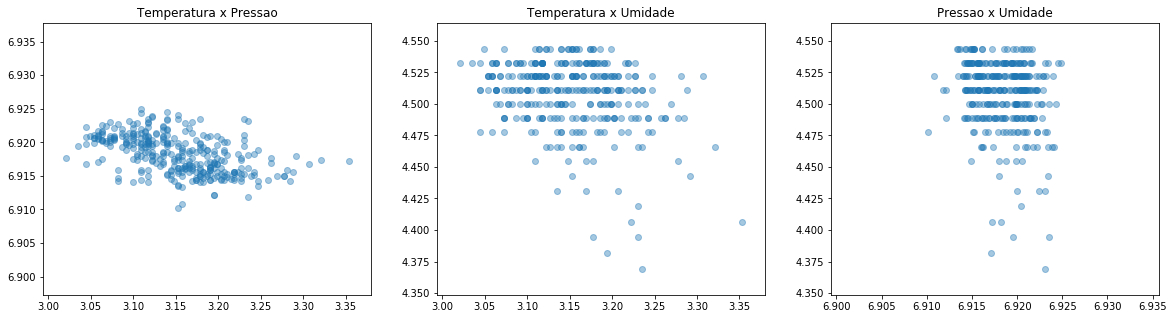

In [47]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura1_log,pressao1_log, alpha=0.4);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1_log,umidade1_log, alpha=0.4);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1_log,umidade1_log, alpha=0.4);
axs[2].set_title('Pressao x Umidade');

### Análise sem log

Novamente, se trata de uma análise a fim de selecionar variáveis independentes que de fato contribuam com o modelo

In [48]:
dados_com_chuva = dados5[dados5['precipitacao']>0]
dados_com_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel,horas,dias,hora_seno,hora_cosseno,dia_seno,dia_cosseno
25,2018-11-07 01:00:00,23.6,1008.7,88,3,13,1,1,0.258819,0.965926,0.017202,0.999852
26,2018-11-07 02:00:00,23.8,1008.6,90,0.2,57,2,1,0.500000,0.866025,0.017202,0.999852
34,2018-11-07 10:00:00,27.4,1008.2,69,0.2,81,10,1,0.500000,-0.866025,0.017202,0.999852
49,2018-11-08 01:00:00,24.1,1009.1,85,0.2,116,1,2,0.258819,0.965926,0.034398,0.999408
50,2018-11-08 02:00:00,22.9,1008.8,89,4.6,129,2,2,0.500000,0.866025,0.034398,0.999408


In [49]:
tempo1 = dados_com_chuva['time']
temperatura1 = dados_com_chuva['temp_inst']
pressao1 = dados_com_chuva['pressao']
umidade1 = dados_com_chuva['umid_inst']
precipitacao1 = dados_com_chuva['precipitacao']

temperatura1 = temperatura1.astype(float)
umidade1 = umidade1.astype(float)
pressao1 = pressao1.astype(float)
precipitacao1 = precipitacao1.astype(float)

temperatura1_log = temperatura1_log.astype(float)
umidade1_log = umidade1_log.astype(float)
pressao1_log = pressao1_log.astype(float)
precipitacao1_log = precipitacao1_log.astype(float)

Scatter plots das variáveis independentes, que passam uma imagem visual da correlação entre elas

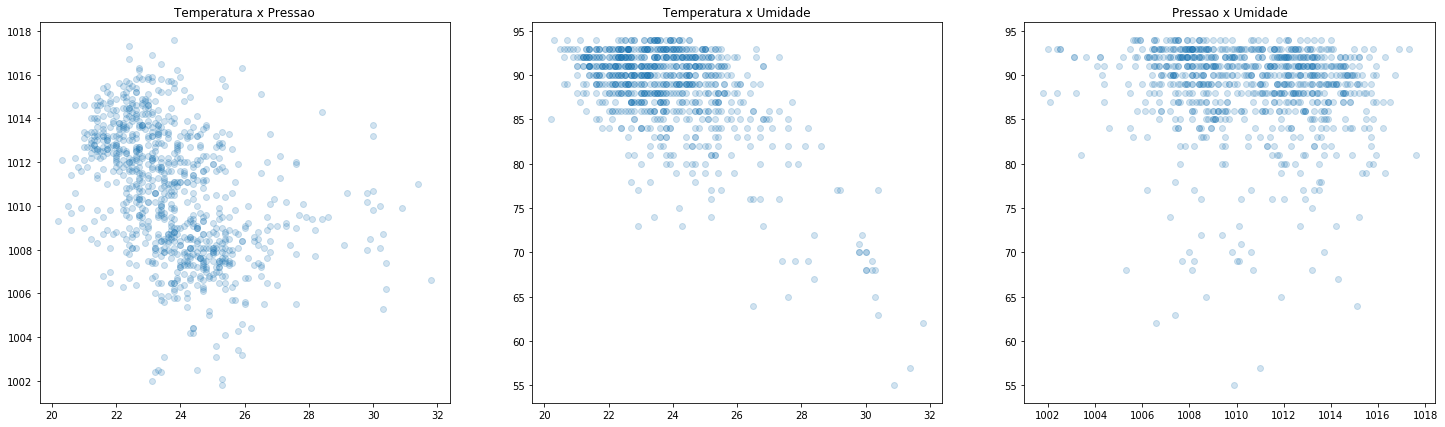

In [50]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,pressao1, alpha=0.2);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1,umidade1, alpha=0.2);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1,umidade1, alpha=0.2);
axs[2].set_title('Pressao x Umidade');

### Correlação entre as variáveis independentes

Cálculo do valor númerico das correlações entre as variáveis independentes

> Sem uso de log

In [51]:
print('Correlação entre temperatura e pressão:', temperatura1.corr(pressao1))
print('Correlação entre temperatura e umidade:', temperatura1.corr(umidade1))
print('Correlação entre pressão e umidade:',pressao1.corr(umidade1))

Correlação entre temperatura e pressão: -0.4076880756078039
Correlação entre temperatura e umidade: -0.5950262535123808
Correlação entre pressão e umidade: -0.10983952939618115


> Com uso de log

In [52]:
print('Correlação entre temperatura e pressão:', np.log10(temperatura1).corr(pressao1))
print('Correlação entre temperatura e umidade:', np.log10(temperatura1).corr(umidade1))
print('Correlação entre pressão e umidade:',np.log10(pressao1).corr(umidade1))

Correlação entre temperatura e pressão: -0.41899232331511677
Correlação entre temperatura e umidade: -0.5725947680905206
Correlação entre pressão e umidade: -0.10983322628566587


O uso de logaritmos nos valores das variáveis ajuda, em certos casos, a mostrar correlações que antes não eram percebidas dado a sua natureza

Scatter plot das variáveis independentes x dependentes com logaritmo, a fim de visualizar possíveis correlações 

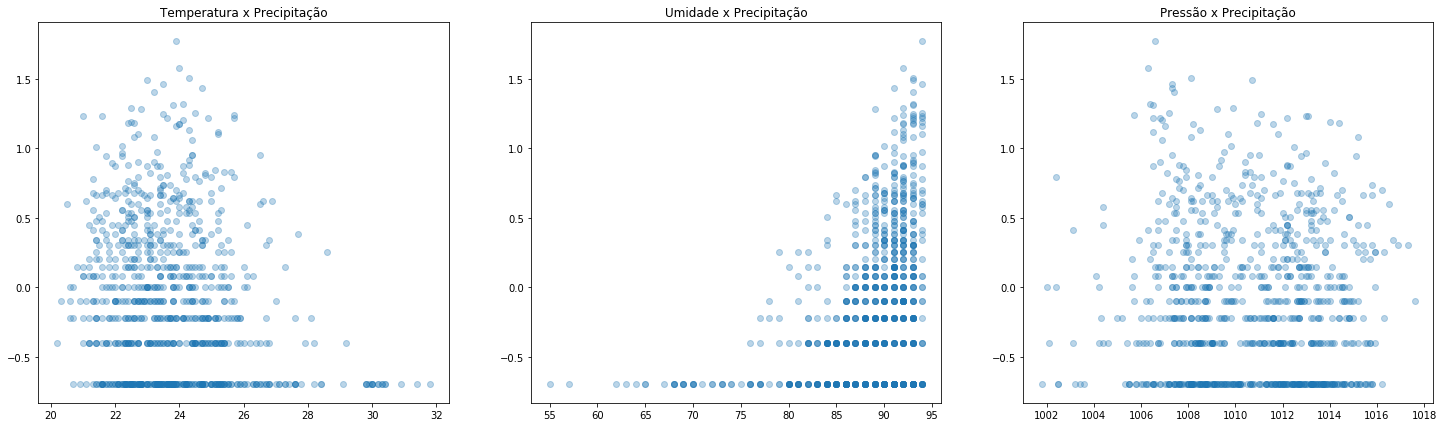

In [53]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,np.log10(precipitacao1), alpha=0.3);
axs[0].set_title('Temperatura x Precipitação');
axs[1].scatter(umidade1,np.log10(precipitacao1), alpha=0.3);
axs[1].set_title('Umidade x Precipitação');
axs[2].scatter(pressao1,np.log10(precipitacao1), alpha=0.3);
axs[2].set_title('Pressão x Precipitação');

### Correlação entre as variáveis independentes e a variável dependente

Este cálculo é crucial para que se perceba quais variáveis podem, de fato contribuir para o modelo. Essa possível contribuição depende da correlação entre as variáveis independentes escolhidas e a variável dependente a ser calculada

> Cálculo sem usar o logaritmo

In [54]:
print('Correlação entre precipitação e pressão:',(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.10332726641360403
Correlação entre precipitação e umidade: 0.2399907881415577
Correlação entre precipitação e umidade: -0.063010637757976


> Cálculo usando o logaritmo

In [55]:
print('Correlação entre precipitação e pressão:', np.log10(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:', np.log10(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',np.log10(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.03963987120695976
Correlação entre precipitação e umidade: 0.4059043809724464
Correlação entre precipitação e umidade: -0.19685016544813258


## Plot de tabelas OLS

As tabelas OLS são usadas para que se possa ter uma noção de como os dados se comportam e como se dão cetos parâmetros relevântes para a análise

In [56]:
model = sm.OLS(np.log10(precipitacao1),sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     170.2
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           1.22e-35
Time:                        19:48:29   Log-Likelihood:                -633.16
No. Observations:                 865   AIC:                             1270.
Df Residuals:                     863   BIC:                             1280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8165      0.287    -13.306      0.000      -4.379      -3.254
umid_inst      0.0422      0.003     13.047      0.000       0.036       0.049
==============================================================================
Omnibus:                       29.729   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.529
Skew:                           0.417   Prob(JB):                     3.87e-07
Kurtosis:                       2.647   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
model = sm.OLS(precipitacao1,sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     52.74
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           8.49e-13
Time:                        19:48:30   Log-Likelihood:                -2471.4
No. Observations:                 865   AIC:                             4947.
Df Residuals:                     863   BIC:                             4956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.3015      2.402     -6.371      0.000     -20.016     -10.587
umid_inst      0.1967      0.027      7.262      0.000       0.144       0.250
==============================================================================
Omnibus:                     1013.997   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99475.571
Skew:                           5.785   Prob(JB):                         0.00
Kurtosis:                      54.246   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
model = sm.OLS(precipitacao1,sm.add_constant(temperatura1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.440
Date:                Tue, 12 Nov 2019   Prob (F-statistic):             0.0640
Time:                        19:48:30   Log-Likelihood:                -2495.4
No. Observations:                 865   AIC:                             4995.
Df Residuals:                     863   BIC:                             5004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7746      1.981      2.915      0.004       1.887       9.663
temp_inst     -0.1542      0.083     -1.855      0.064      -0.317       0.009
==============================================================================
Omnibus:                     1016.266   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96316.032
Skew:                           5.826   Prob(JB):                         0.00
Kurtosis:                      53.364   Cond. No.                         321.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___
## Analisando os dias que não tiveram chuvas

##### Análise com log

In [59]:
dados_log_sem_chuva = dados_log[dados_log['precipitacao']==0]
dados_log_sem_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-22 05:00:00,3.169686,6.916517,4.488636,0.0,4.700480
2018-11-26 22:00:00,3.072693,6.916418,4.521789,0.0,4.330733
2018-11-26 23:00:00,3.077312,6.916616,4.521789,0.0,5.170484
2018-11-27 22:00:00,3.025291,6.916616,4.488636,0.0,3.784190
2018-12-02 08:00:00,3.190476,6.911946,4.521789,0.0,3.583519


In [60]:
temperatura2_log = dados_log_com_chuva['temp_inst']
pressao2_log = dados_log_com_chuva['pressao']
umidade2_log = dados_log_com_chuva['umid_inst']
precipitacao2_log = dados_log_com_chuva['precipitacao']

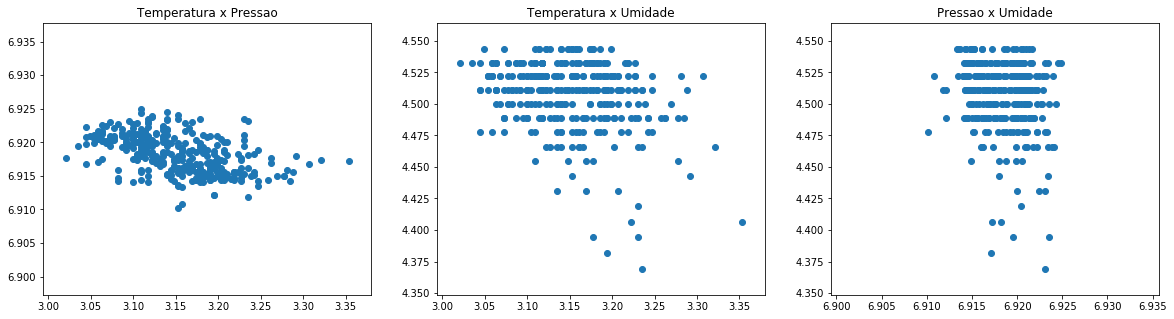

In [61]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2_log,pressao2_log);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura2_log,umidade2_log);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2_log,umidade2_log);
axs[2].set_title('Pressao x Umidade');

##### Análise sem log

In [62]:
dados_sem_chuva = dados5[dados5['precipitacao']==0]
dados_sem_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel,horas,dias,hora_seno,hora_cosseno,dia_seno,dia_cosseno
0,2018-11-06 00:00:00,25.3,1008.1,76,0,74,0,0,0.000000,1.000000,0.0,1.0
1,2018-11-06 01:00:00,25.2,1008.1,78,0,69,1,0,0.258819,0.965926,0.0,1.0
2,2018-11-06 02:00:00,25.1,1007.6,78,0,90,2,0,0.500000,0.866025,0.0,1.0
3,2018-11-06 03:00:00,25.2,1007.1,79,0,95,3,0,0.707107,0.707107,0.0,1.0
4,2018-11-06 04:00:00,24.7,1006.7,77,0,58,4,0,0.866025,0.500000,0.0,1.0


In [63]:
tempo2 = dados_sem_chuva['time']
temperatura2 = dados_sem_chuva['temp_inst']
pressao2 = dados_sem_chuva['pressao']
umidade2 = dados_sem_chuva['umid_inst']
precipitacao2 = dados_sem_chuva['precipitacao']

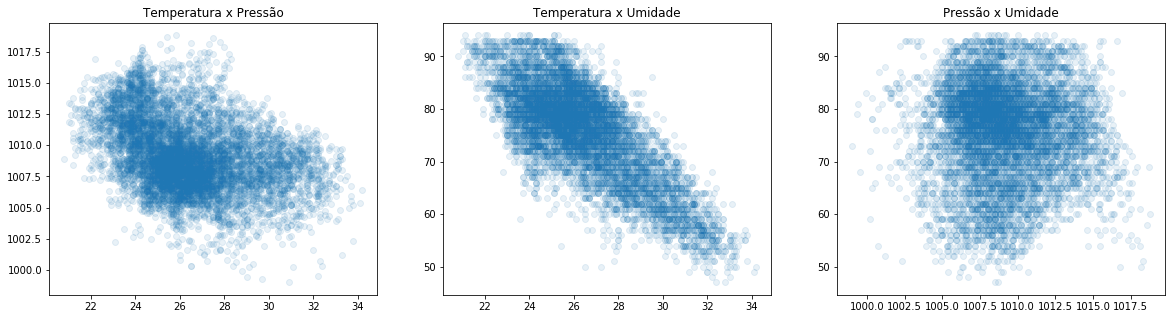

In [64]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2,pressao2, alpha=0.1);
axs[0].set_title('Temperatura x Pressão');
axs[1].scatter(temperatura2,umidade2, alpha=0.1);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2,umidade2, alpha=0.1);
axs[2].set_title('Pressão x Umidade');

***Valores de correlação entre as variáveis***

In [65]:
temperatura2 = temperatura2.astype(float)
umidade2 = umidade2.astype(float)
pressao2 = pressao2.astype(float)
print('Correlação entre temperatura e pressão:', temperatura2.corr(pressao2))
print('Correlação entre temperatura e umidade:', temperatura2.corr(umidade2))
print('Correlação entre pressão e umidade:',pressao2.corr(umidade2))

Correlação entre temperatura e pressão: -0.37013423515633453
Correlação entre temperatura e umidade: -0.7607690347330321
Correlação entre pressão e umidade: -0.023401373426295346


In [66]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [67]:
Y = dados5['precipitacao'].astype(float)

In [68]:
X3 = dados5[['temp_inst', 'pressao', 'umid_inst']].astype(float)

results3 = regress(X3, Y)
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     138.1
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           2.01e-87
Time:                        19:48:32   Log-Likelihood:                -15772.
No. Observations:                8745   AIC:                         3.155e+04
Df Residuals:                    8741   BIC:                         3.158e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.2896      7.082     -4.841      0.000     -48.173     -20.406
temp_inst      0.0533      0.013      4.170      0.000       0.028       0.078
pressao        0.0295      0.007      4.411      0.000       0.016       0.043
umid_inst      0.0428      0.003     14.252      0.000       0.037       0.049
==============================================================================
Omnibus:                    18011.871   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         76183266.007
Skew:                          17.295   Prob(JB):                         0.00
Kurtosis:                     458.942   Cond. No.                     4.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
# X3 = dados5[['temp_inst', 'pressao', 'umid_inst', 'dia cosseno','dia seno','hora seno','hora cosseno']].astype(float)

# results3 = regress(X3, Y)
# results3.summary()
np.log10(dados5['temp_inst'])

AttributeError: 'float' object has no attribute 'log10'